In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [12]:
file_path = '../../data_storage/CyberBullying_balancedData.csv'  # Replace with your actual file path
cleaned_data = pd.read_csv(file_path)

In [5]:
# Inspect the cleaned dataset
print(cleaned_data.info())
print(cleaned_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32378 entries, 0 to 32377
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    32378 non-null  object
 1   Label   32378 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 506.0+ KB
None
                                                Text  Label
0                           u0 lmao wow fuck you too      0
1  a white dress and red lipstick make everything...      0
2  this has been a trend since <number> of course...      0
3  <user> <user> babies in cages destroying envir...      0
4  <user> more good neighbours yes that working o...      0


In [13]:
# Check the label distribution
label_distribution = cleaned_data['Label'].value_counts()

# Print the cleaned label distribution
print("Label Distribution:")
print(label_distribution)

Label Distribution:
Label
1    17723
0    14655
Name: count, dtype: int64


In [14]:
# Convert labels to integers for visualization
cleaned_data['Label'] = cleaned_data['Label'].astype(int)

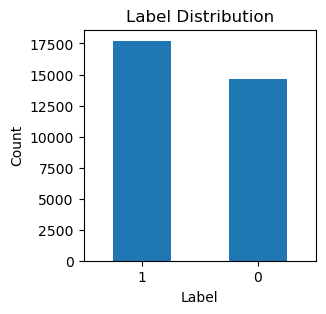

In [15]:
# Plot the label distribution
plt.figure(figsize=(3, 3))
label_distribution.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [20]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:

# Define text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove tags like <xyz>
    text = re.sub(r'<[^>]+>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove the word 'u0'
    text = re.sub(r'\bu0\b', '', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply preprocessing to the dataset
cleaned_data['Cleaned_Text'] = cleaned_data['Text'].apply(preprocess_text)
cleaned_data.head()

,Text,Label,Cleaned_Text
0,u0 lmao wow fuck you too,0,lmao wow fuck
1,a white dress and red lipstick make everything...,0,white dress red lipstick make everything better
2,this has been a trend since <number> of course...,0,trend since course wall street assumed eternal...
3,<user> <user> babies in cages destroying envir...,0,baby cage destroying environment rolling back ...
4,<user> more good neighbours yes that working o...,0,good neighbour yes working well crime skyrocke...


In [22]:
# Analyze text lengths (word and character counts)
cleaned_data['Word_Count'] = cleaned_data['Cleaned_Text'].apply(lambda x: len(x.split()))
cleaned_data['Char_Count'] = cleaned_data['Cleaned_Text'].apply(len)

# Display basic statistics
print("Word Count Stats:")
print(cleaned_data['Word_Count'].describe())

print("\nCharacter Count Stats:")
print(cleaned_data['Char_Count'].describe())

# Most common words in the cleaned text
all_cleaned_words = ' '.join(cleaned_data['Cleaned_Text']).split()
word_freq = Counter(all_cleaned_words)
print("\nMost Common Words in Cleaned Text:")
print(word_freq.most_common(10))

Word Count Stats:
count    32378.000000
mean        22.293502
std         51.725793
min          0.000000
25%          7.000000
50%         11.000000
75%         17.000000
max       2303.000000
Name: Word_Count, dtype: float64

Character Count Stats:
count    32378.000000
mean       135.302953
std        323.977306
min          0.000000
25%         38.000000
50%         64.000000
75%         98.000000
max      14007.000000
Name: Char_Count, dtype: float64

Most Common Words in Cleaned Text:
[('like', 8041), ('fuck', 7594), ('u', 5924), ('nigger', 5785), ('im', 5761), ('joke', 5551), ('dumb', 5487), ('dont', 5255), ('people', 4861), ('gay', 4712)]


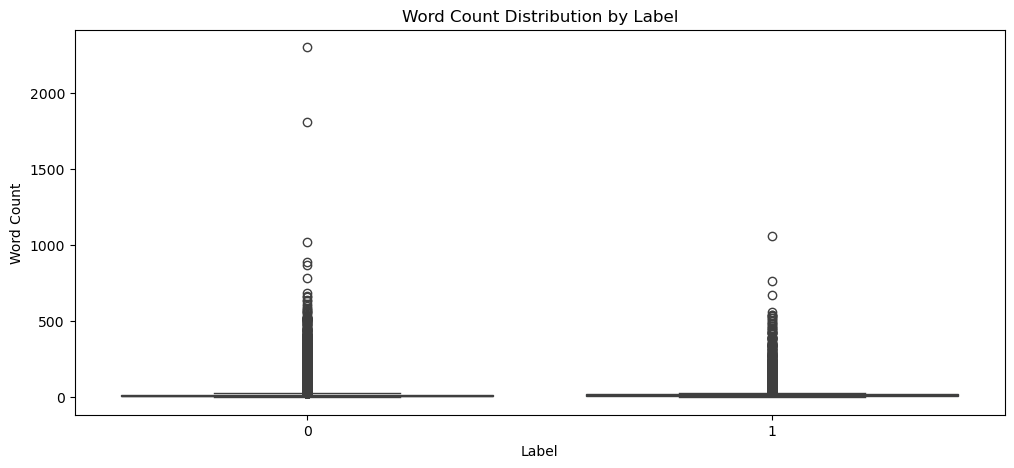

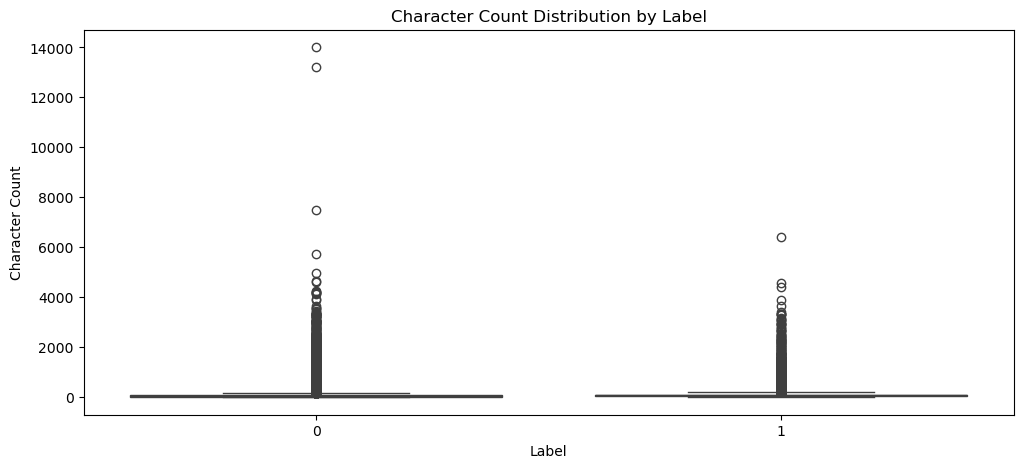

In [23]:
# Text Length Distribution by Label
plt.figure(figsize=(12, 5))
sns.boxplot(data=cleaned_data, x='Label', y='Word_Count')
plt.title('Word Count Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Word Count')
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=cleaned_data, x='Label', y='Char_Count')
plt.title('Character Count Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Character Count')
plt.show()

In [24]:
# Common Words Analysis per Label
labels = cleaned_data['Label'].unique()
for label in labels:
    label_text = ' '.join(cleaned_data[cleaned_data['Label'] == label]['Cleaned_Text'])
    label_words = label_text.split()
    word_freq = Counter(label_words)
    print(f"\nMost Common Words for Label {label}:")
    print(word_freq.most_common(10))


Most Common Words for Label 0:
[('like', 5073), ('im', 3300), ('love', 3101), ('dont', 2904), ('u', 2810), ('get', 2567), ('one', 2450), ('video', 2431), ('lol', 2394), ('people', 2194)]

Most Common Words for Label 1:
[('fuck', 6572), ('nigger', 5731), ('joke', 5356), ('dumb', 5284), ('gay', 4155), ('rape', 4113), ('u', 3114), ('like', 2968), ('people', 2667), ('as', 2649)]


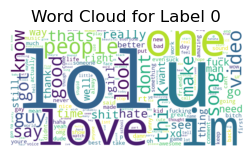

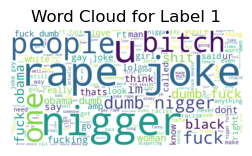

In [25]:
# Generate Word Clouds for Each Label
for label in labels:
    label_text = ' '.join(cleaned_data[cleaned_data['Label'] == label]['Cleaned_Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(label_text)
    
    plt.figure(figsize=(3, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label {label}')
    plt.axis('off')
    plt.show()

In [26]:
# Analyze Pattern Frequency (Optional)
cleaned_data['Has_Mention'] = cleaned_data['Text'].apply(lambda x: '@' in str(x))
cleaned_data['Has_Hashtag'] = cleaned_data['Text'].apply(lambda x: '#' in str(x))

pattern_summary = cleaned_data[['Label', 'Has_Mention', 'Has_Hashtag']].groupby('Label').mean()
print("\nText Pattern Summary by Label (Mentions & Hashtags):")
print(pattern_summary)


Text Pattern Summary by Label (Mentions & Hashtags):
       Has_Mention  Has_Hashtag
Label                          
0         0.314705     0.175708
1         0.378153     0.136771


In [27]:
# Download NLTK resources for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...


True

In [28]:
# Function to extract and display n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngrams = vectorizer.fit_transform(corpus)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_vocab = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_vocab, ngram_counts))
    sorted_ngrams = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    return sorted_ngrams[:top_n]

# Analyze n-grams for each label
labels = cleaned_data['Label'].unique()
for label in labels:
    label_text = cleaned_data[cleaned_data['Label'] == label]['Cleaned_Text']
    print(f"\nTop 10 Bigrams for Label {label}:")
    print(get_top_ngrams(label_text, ngram_range=(2, 2), top_n=10))

    print(f"\nTop 10 Trigrams for Label {label}:")
    print(get_top_ngrams(label_text, ngram_range=(3, 3), top_n=10))


Top 10 Bigrams for Label 0:
[('look like', 478), ('gon na', 391), ('dont know', 330), ('wan na', 303), ('sound like', 270), ('year old', 233), ('love song', 223), ('dont like', 190), ('fake fake', 158), ('got ta', 149)]

Top 10 Trigrams for Label 0:
[('fake fake fake', 150), ('mild mild mild', 111), ('im gon na', 105), ('minzy minzy minzy', 76), ('ha ha ha', 65), ('bloobidy bloobidy bloobidy', 50), ('im pretty sure', 50), ('peoplesearch youtube video', 50), ('video swilon oo', 50), ('youtube video swilon', 50)]

Top 10 Bigrams for Label 1:
[('dumb nigger', 2324), ('rape joke', 2150), ('dumb fuck', 1091), ('fuck obama', 998), ('obama dumb', 983), ('gay joke', 764), ('fuck dumb', 696), ('rt fuck', 576), ('joke gay', 506), ('joke rape', 457)]

Top 10 Trigrams for Label 1:
[('fuck obama dumb', 978), ('obama dumb nigger', 903), ('rt fuck obama', 478), ('fuck dumb nigger', 458), ('gay rape joke', 285), ('rt im sexist', 252), ('rape joke gay', 239), ('joke gay joke', 189), ('joke rape joke',


Sentiment Summary by Label:
       Sentiment_Positive  Sentiment_Negative  Sentiment_Neutral  \
Label                                                              
0                0.138143            0.154362           0.707294   
1                0.100545            0.289351           0.610101   

       Sentiment_Compound  
Label                      
0                0.027603  
1               -0.429832  


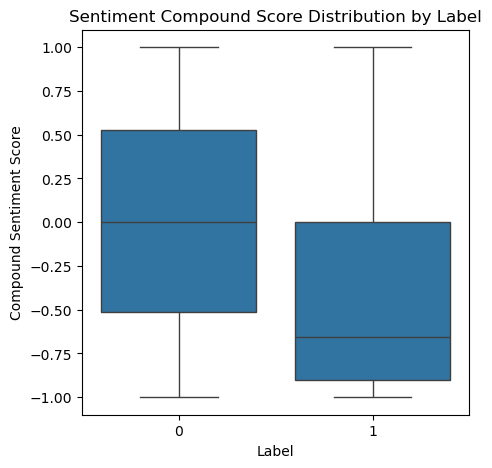

In [29]:
# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the dataset
cleaned_data['Sentiment'] = cleaned_data['Text'].apply(analyze_sentiment)

# Extract sentiment metrics
cleaned_data['Sentiment_Positive'] = cleaned_data['Sentiment'].apply(lambda x: x['pos'])
cleaned_data['Sentiment_Negative'] = cleaned_data['Sentiment'].apply(lambda x: x['neg'])
cleaned_data['Sentiment_Neutral'] = cleaned_data['Sentiment'].apply(lambda x: x['neu'])
cleaned_data['Sentiment_Compound'] = cleaned_data['Sentiment'].apply(lambda x: x['compound'])


numeric_sentiment_columns = ['Sentiment_Positive', 'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Compound']

# Group by label and calculate the mean only for numeric columns
sentiment_summary = cleaned_data.groupby('Label')[numeric_sentiment_columns].mean()

# Display the sentiment summary
print("\nSentiment Summary by Label:")
print(sentiment_summary)

# Visualize sentiment distributions
plt.figure(figsize=(5,5 ))
sns.boxplot(data=cleaned_data, x='Label', y='Sentiment_Compound')
plt.title('Sentiment Compound Score Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Compound Sentiment Score')
plt.show()

In [30]:
# Step 1: Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = tfidf.fit_transform(cleaned_data['Cleaned_Text']).toarray()
y = cleaned_data['Label'].astype(int)

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization type
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Optimization algorithm
    'max_iter': [100, 500, 1000]  # Maximum iterations
}

# Initialize Logistic Regression
logistic = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Logistic Regression model with the best parameters
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the tuned model
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Hyperparameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [32]:
print("\nModel Evaluation After Hyperparameter Tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation After Hyperparameter Tuning:
Accuracy: 0.8810994441012971

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      2931
           1       0.93      0.85      0.89      3545

    accuracy                           0.88      6476
   macro avg       0.88      0.88      0.88      6476
weighted avg       0.89      0.88      0.88      6476



In [33]:

# Train the final Logistic Regression model with the best parameters
final_model = LogisticRegression(C=1, max_iter=100, penalty='l2', solver='lbfgs')
final_model.fit(X_train, y_train)

# Predict on the test data
y_pred = final_model.predict(X_test)

# Evaluate the model
print("\nFinal Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))





Final Model Evaluation:
Accuracy: 0.8810994441012971

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      2931
           1       0.93      0.85      0.89      3545

    accuracy                           0.88      6476
   macro avg       0.88      0.88      0.88      6476
weighted avg       0.89      0.88      0.88      6476



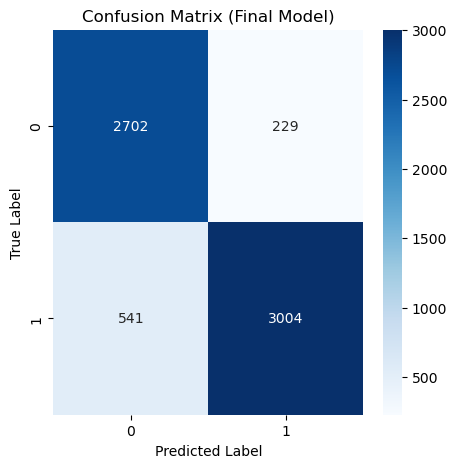

In [34]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=final_model.classes_, yticklabels=final_model.classes_)
plt.title('Confusion Matrix (Final Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()